![](https://www.clipartkey.com/mpngs/m/196-1966407_national-data-science-bowl-data-science-bowl-logo.png)

###  <center>Imagine accelerating research on almost all diseases, from lung cancer and heart disease to rare diseases. Data Science Bowl offers our most ambitious mission: to create an algorithm for automatic detection of cores.</center>  

### <center>This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations</center> 

 -------------------

In [1]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2

import tensorflow as tf
from keras import backend as K

from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
with zipfile.ZipFile("../input/data-science-bowl-2018/stage1_train.zip",'r') as z:
    z.extractall("stage1_train")

with zipfile.ZipFile("../input/data-science-bowl-2018/stage2_test_final.zip",'r') as z:
    z.extractall("stage2_test_final")

In [3]:
train_path = '/kaggle/working/stage1_train/'
test_path = '/kaggle/working/stage2_test_final/'

In [4]:
train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)



















---------------------------

# <center>Loading data</center>

![](https://www.grantauto.ru/include/section_loader.gif)

First, let's create empty tensors for future images

In [5]:
X_train = np.zeros((len(train_dir), 256, 256, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_dir), 256, 256, 1), dtype=bool)

X_test = np.zeros((len(test_dir), 256, 256, 3), dtype=np.uint8)

The directory structure looks like each **Spot Nuclei** has its own folder.

The folder with **id Spot Nuclei** contains two folders: **images** and **masks**

images contains the original **Spot Nuclei image**. We need to write it **into a pre-created tensor X**

masks contains several images with **different parts of the masks**. We need to **merge all the masks into one image** using **np.maximum**. Further, just as with the original image, write to the **pre-created tensor Y**

We will **compress all images** to a size of **256x256x3**, however, we will set the size of **mask images** to **256x256x1**, since it makes no sense for us to store them in **rgb format**

In [6]:
%%time
for i, name in enumerate(train_dir):
    path = train_path + name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real,(256,256))
    X_train[i] = img_real
    
    img_segment_full = np.zeros((256, 256 , 1), dtype=bool)
    segment_path = path+'/masks/'
    for name in os.listdir(segment_path):
        img_segment = cv2.imread(segment_path + name, 0)
        img_segment = cv2.resize(img_segment, (256, 256))
        img_segment = np.expand_dims(img_segment, axis=-1)
        img_segment_full = np.maximum(img_segment_full, img_segment)
    
    Y_train[i] = img_segment_full

CPU times: user 23.9 s, sys: 780 ms, total: 24.7 s
Wall time: 24.9 s


In [7]:
%%time
for i, name in enumerate(test_dir):
    path = test_path + name
    img_real = cv2.imread(path+'/images/'+ name +'.png')
    img_real = cv2.resize(img_real, (256,256))
    X_test[i] = img_real

libpng warning: Ignoring PLTE chunk in grayscale PNG


CPU times: user 12.1 s, sys: 432 ms, total: 12.5 s
Wall time: 12.5 s


Ok, let's see the result.

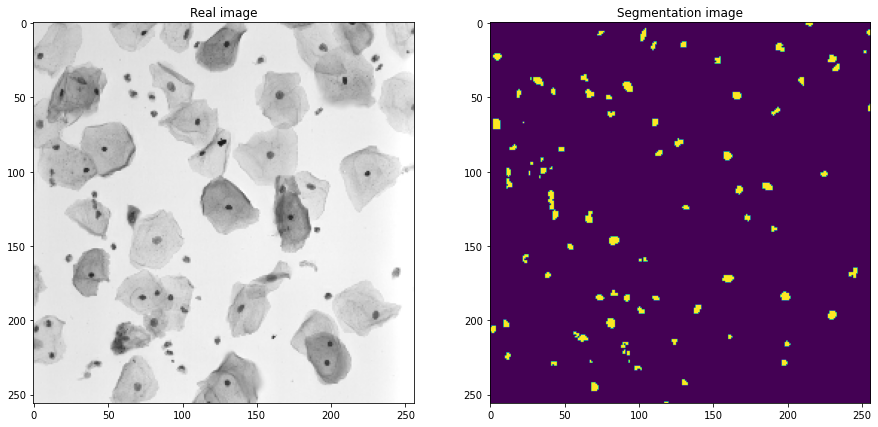

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(X_train[2])
plt.title('Real image')
plt.subplot(122)
plt.imshow(Y_train[2])
plt.title('Segmentation image');

Looks good, now let's work on augmenting our images


--------------------------------

#  <center>Data Preprocessing</center>


![](https://iprofi.kg/wp-content/uploads/2021/07/60ffd0153c1d3549690580.gif)


-------------------

**U-net** does not require a large amount of data, as for example for the classification task, however, there are only **670 data** in the train, I believe that **augmentation** here can improve the segmentation result

In [9]:
aug_gen_args = dict(shear_range = 0.2,
                    zoom_range = 0.2,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect'
                   )

X_train_gen = ImageDataGenerator(**aug_gen_args)
y_train_gen = ImageDataGenerator(**aug_gen_args)
X_val_gen = ImageDataGenerator()
y_val_gen = ImageDataGenerator()

To begin with, let's demonstrate on one image what augmentation looks like.

It is important to set the **seed** and **shuffle=False** in order for the **original augmented images** to match the **segmented augmented images**.

In [10]:
aug_image_real = X_train[5].reshape((1,)+X_train[1].shape)
aug_image_seg = Y_train[5].reshape((1,)+Y_train[1].shape)

In [11]:
aug_image_real_check = X_train_gen.flow(aug_image_real, batch_size=1, seed=17, shuffle=False)
aug_image_seg_check = y_train_gen.flow(aug_image_seg, batch_size=1, seed=17, shuffle=False)

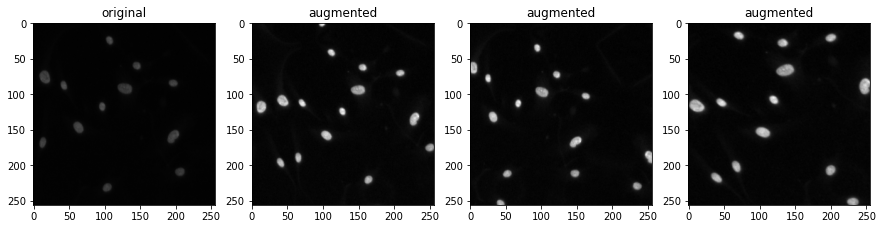

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(X_train[5])
plt.title("original")
i=2
for batch in aug_image_real_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

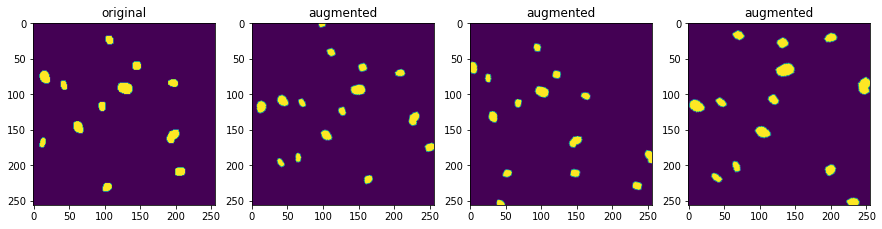

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(141)
plt.imshow(Y_train[5])
plt.title("original")
i=2
for batch in aug_image_seg_check:
    plt.subplot(14*10+i)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title("augmented")
    i += 1
    if i % 5 == 0:
        break

Looks good, now let's split **X_train** into **2 parts**: **train** and **val**. For val of the selection, select **0.1 data size**

Next, **apply the augmentation generators** to the train data; no augmentation will be performed for the val data

Since we need to do augmentation for original images and segmented images, then we **need to combine the generators** into one using the **zip()**

In [14]:
train, val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=17)

In [15]:
X_train_gen.fit(train, augment=True, seed=17)
y_train_gen.fit(y_train, augment=True, seed=17)
X_val_gen.fit(val, seed=17)
y_val_gen.fit(y_val, seed=17)

X_train_generator = X_train_gen.flow(train, batch_size=16, seed=17, shuffle=False)
y_train_generator = y_train_gen.flow(y_train, batch_size=16, seed=17, shuffle=False)
X_val_generator = X_val_gen.flow(val, batch_size=16, seed=17, shuffle=False)
y_val_generator = y_val_gen.flow(y_val, batch_size=16, seed=17, shuffle=False)

train_generator = zip(X_train_generator, y_train_generator)
val_generator = zip(X_val_generator, y_val_generator)

Great, now let's create a custom metric that is required in this competition


--------------------------

#  <center>Creating custom metric and loss</center>

### IoU metric

This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds.

I have seen implementations in other kernels, they all use the built-in **tf.keras.metrics.MeanIoU** function to calculate **IoU**, and then average the results over **thresholds of 0.05**.

I'm not sure that it works correctly and I tried to implement my own version of the **MeanIoU** metric for the competition.

First, I wrote a function to calculate IoU:

1) Calculate intersection
2) Calculate union

**P.S** In many IoU implementations on the Internet, I have not seen people subtract intersection from union, however, I think this is necessary, since we sum the intersection part 2 times instead of one. In this way, we stick with the set.union() implementation for sets.

**!!!!CORRECT ME IF I AM WRONG!!!!**

3) Calculate intersection/union

![](https://images.viblo.asia/1f53756b-5271-4d27-824c-180043f47ebe.png)

To calculate **mean_iou**, we calculate the **IoU for each threshold using a loop**, passing **t_y_pred** of type **float32**

**P.S** I don’t know why, but the model reports an error if we pass any other data type to it, although we still get int values at the output

**!!!!!CORRECT ME IF I AM WRONG!!!!!**

after counting the values of all threshold values t, we **average and return the result**

In [16]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

In [17]:
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

### Dice loss

Also for U-net, **dice_loss** or **binary crossentropy** is most often used, in this work I tried to use **dise_loss**

However, **IoU_loss** could also be used, but as I understand it, this metric **cannot be differentiated**

**!!!!!CORRECT ME IF I AM WRONG!!!!!**

![](https://fooobar.com/img/e7683d03a1e317c73bdbaafd343803d3.png)

In [18]:
def dice_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + 1) / (union + 1), axis=0)
    return 1. - dice

Great, now let's write the basic architecture of the model


-------------------------

#  <center>U-NET model</center>

![](https://www.mdpi.com/remotesensing/remotesensing-11-02970/article_deploy/html/images/remotesensing-11-02970-g001-550.jpg)

1. We feed the **Input() layer** with the size of the input images to the **U-NET input**, then using **Lambda** we **normalize** our image to a network-friendly range **(0:1)**

U-net architecture can be divided into two parts: **encoder and decoder**

2. **ENCODER**

 encoder is a typical CNN architecture. It consists of:

* encoder consists of reapplying **Conv2D 3x3**;
* In order not to lose border pixels during convolution, we use **padding**;
* On each layer we apply **ReLU activation**;
* Next comes **MaxPooling2D 2x2** for downsampling;
* At each encoder step, the filter channels are doubled, we'll **start at 32 and end at 512**;

3. **DECODER**

Each step in the expanding path consists of a property map upsampling operation. It consists of:

* **UpSampling2D 2×2**, which reduces the number of filter channels;
* **concatenate** to link layers to the same property map;
* Re-apply **Conv2D 3×3**;
* In order not to lose border pixels during convolution, we use **padding**;
* On each layer we apply **ReLU activation**;
* At each step of the encoder, the filter channels are halved, we will **start at 512 and end at 32**;


4. The last layer uses **Conv2D 1x1** to map each feature vector to the **desired class**.

In [19]:
inputs = Input((256, 256, 3))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = UpSampling2D(size=(2,2))(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = UpSampling2D(size=(2,2))(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = UpSampling2D(size=(2,2))(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = UpSampling2D(size=(2,2))(conv8)
up9 = concatenate([up9, conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = models.Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss=dice_loss, metrics=mean_iou)

2022-02-22 23:45:48.722564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 23:45:48.833456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 23:45:48.834144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 23:45:48.835124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

using **optimizer='Adam'** as the most basic and recommended, but for **better accuracy**, I **lowered the learning_rate**

**loss='dice_loss'** we defined it with the **dice_loss** function earlier

**metrics='mean_iou'** we defined it with the **mean_iou** function earlier

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

------------------------------------------

#  <center>U-net model training</center>

---------------------

![](http://mianbaoban-assets.oss-cn-shenzhen.aliyuncs.com/2020/2/Yzaemm.gif)

Ok, now let's start training our model.

Pass **train and val generators**

Set the **train/val epoch size** as **len(train/val)/bath_size**

Let's set **epochs=25**, I think this is enough to get good results

P.S. I won't use callbacks as a model with such a small amount of data and 25 epochs will learn quickly.

In [21]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train)/8,
                    validation_data=val_generator,
                    validation_steps=len(val)/8,
                    epochs=25
                   )

2022-02-22 23:45:51.578577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-02-22 23:45:54.035205: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 38s 373ms/step - loss: 0.4760 - mean_iou: 0.4943 - val_loss: 0.2408 - val_mean_iou: 0.7061
Epoch 2/25
75/75 [==============================] - 25s 330ms/step - loss: 0.2098 - mean_iou: 0.7004 - val_loss: 0.1357 - val_mean_iou: 0.7962
Epoch 3/25
75/75 [==============================] - 25s 334ms/step - loss: 0.1577 - mean_iou: 0.7595 - val_loss: 0.1190 - val_mean_iou: 0.8215
Epoch 4/25
75/75 [==============================] - 25s 334ms/step - loss: 0.1458 - mean_iou: 0.7748 - val_loss: 0.1066 - val_mean_iou: 0.8361
Epoch 5/25
75/75 [==============================] - 25s 331ms/step - loss: 0.1467 - mean_iou: 0.7742 - val_loss: 0.1120 - val_mean_iou: 0.8303
Epoch 6/25
75/75 [==============================] - 25s 328ms/step - loss: 0.1702 - mean_iou: 0.7469 - val_loss: 0.1107 - val_mean_iou: 0.8292
Epoch 7/25
75/75 [==============================] - 25s 333ms/step - loss: 0.1478 - mean_iou: 0.7727 - val_loss: 0.1050 - val_mean_iou: 0.8377
Epoch 8/25

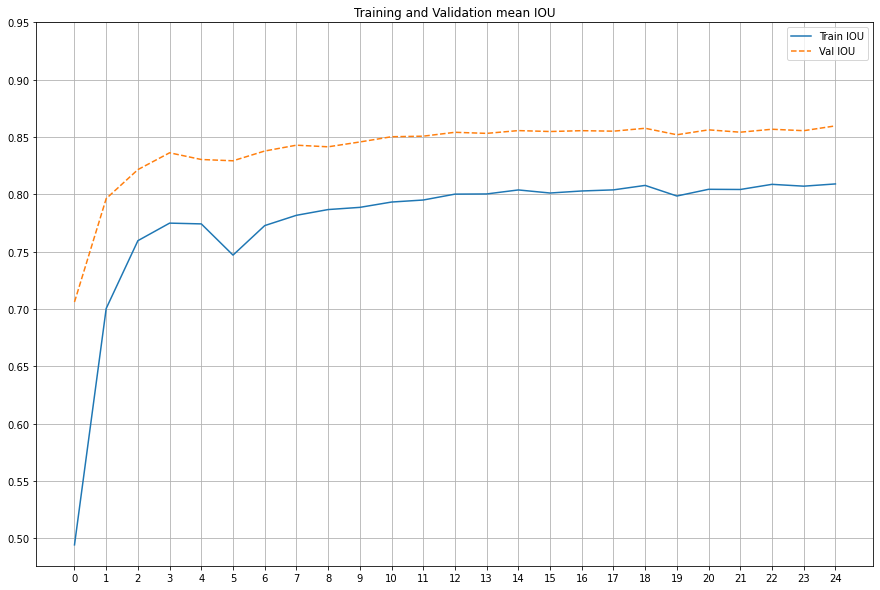

In [22]:
loss = history.history['mean_iou']
val_loss = history.history['val_mean_iou']

plt.figure(figsize=(15,10))
plt.plot(loss, label='Train IOU')
plt.plot(val_loss,'--', label='Val IOU')
plt.title('Training and Validation mean IOU')
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(np.arange(0, 25))
plt.grid()
plt.legend();

Great, we see that the average result for **Val_IoU is ~0.85** **Train_IoU ~0.8**



Let's take a look at the results in images

------------------------------------

#   <center>Result on train/val data</center> 

In [23]:
train_pred = model.predict(train, verbose = 1)
val_pred = model.predict(val, verbose=1)

3/3 [==============================] - 0s 82ms/step


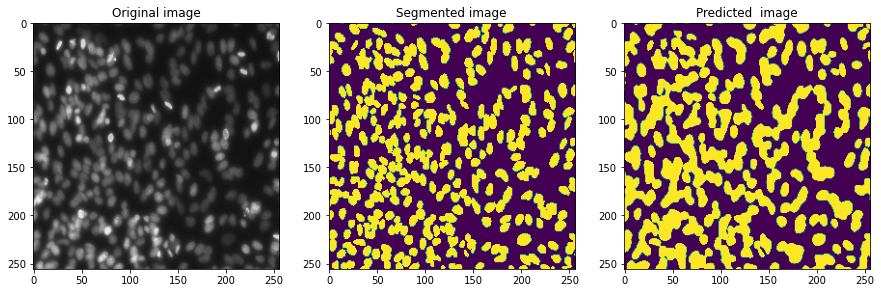

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(train[1])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_train[1]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(train_pred[1]))
plt.title('Predicted  image');

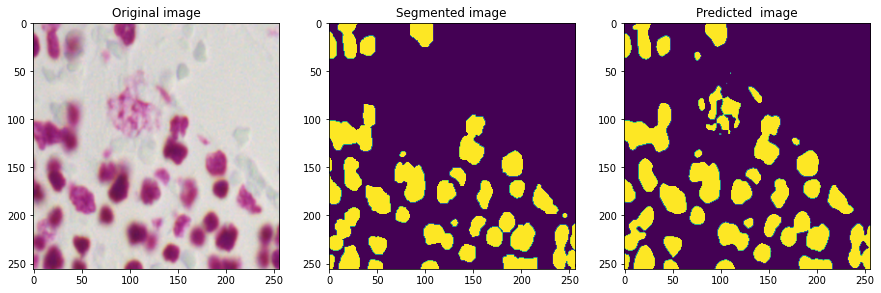

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(val[3])
plt.title('Original image')
plt.subplot(132)
plt.imshow(np.squeeze(y_val[3]))
plt.title('Segmented image')
plt.subplot(133)
plt.imshow(np.squeeze(val_pred[3]))
plt.title('Predicted  image');

Great, it looks like the neural network really works, now let's **predict** the result for **X_test data**.

I won't be submitting on kaggle as the competition is over. The purpose of this notebook is to learn how to use **U-net for image segmentation**

 -------------------------

#   <center>Result on test data</center>

In [26]:
test_pred = model.predict(X_test, verbose=1)

95/95 [==============================] - 8s 81ms/step


2022-02-22 23:56:44.858077: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 791412736 exceeds 10% of free system memory.


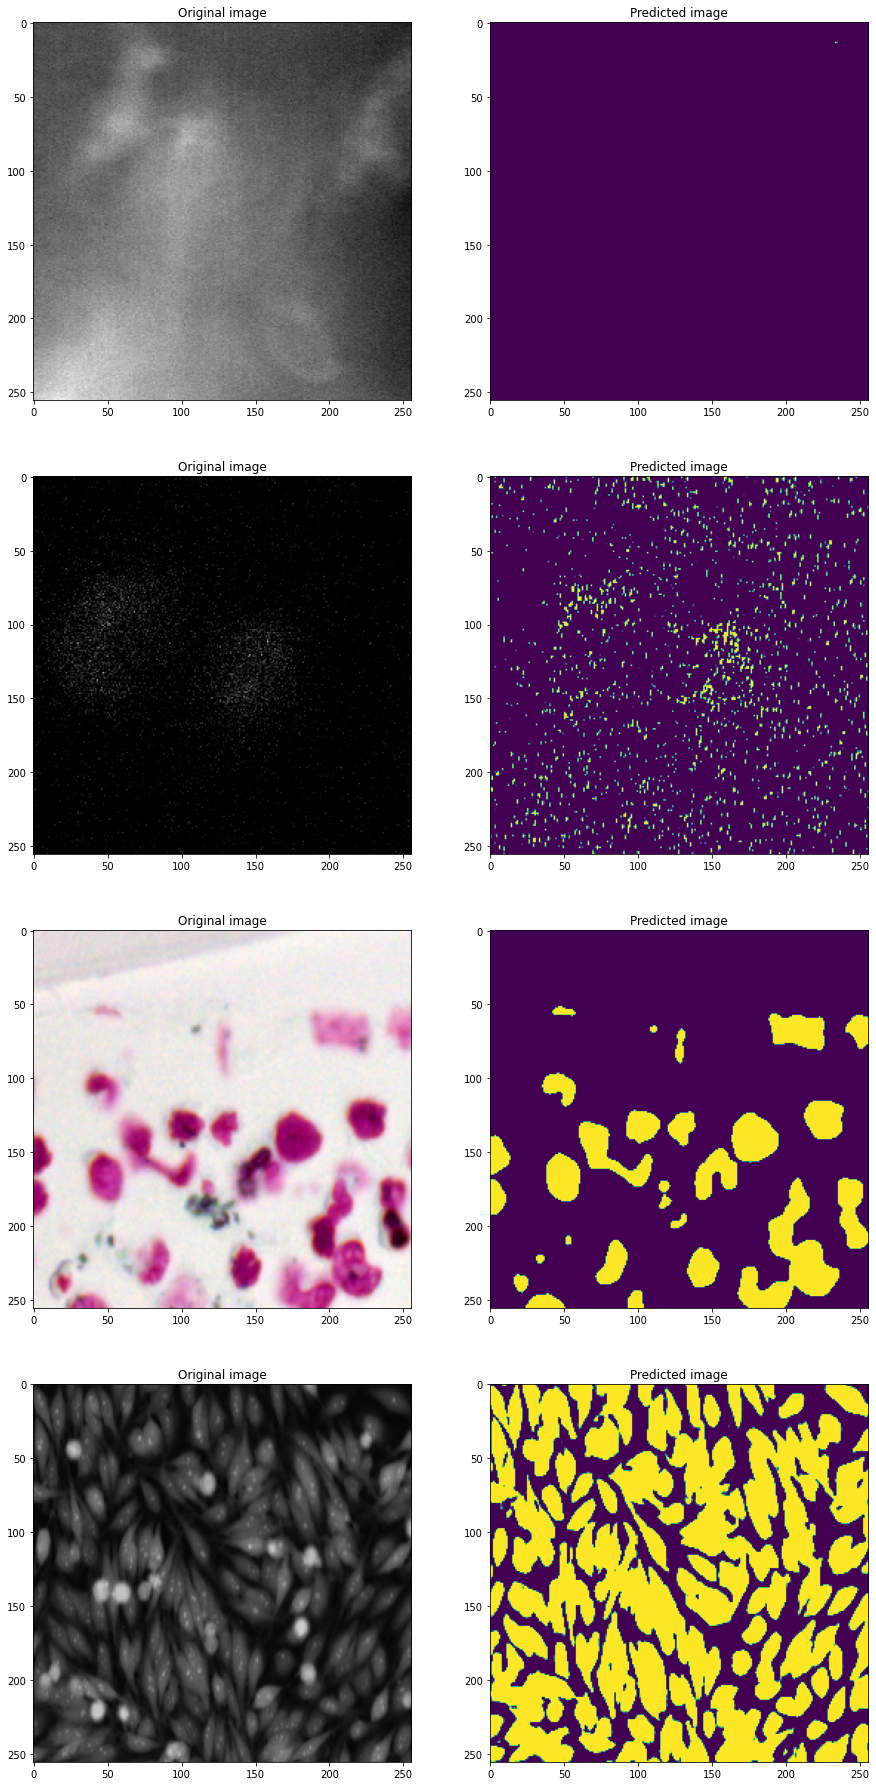

In [27]:
plt.figure(figsize=(15, 32))
for i in range(421, 429):
    plt.subplot(i)
    if i % 2!=0:
        plt.imshow(X_test[i])
        plt.title('Original image')
    else:
        plt.imshow(np.squeeze(test_pred[i-1]))
        plt.title('Predicted image')

 --------------------

##  <center>Thank you for watching this is my project, I will be grateful if you upvoted and give feedback about my work in the comments. I want to improve my skills, and if you find any mistakes in the work, please tell me about it. </center>

![](https://data.whicdn.com/images/218833361/original.gif)